In [1]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd

# Question 1:

The dataset we've used in the lecture had many values very close to eachother, forming a straight line with a slope very close to zero. This meant, the best fitting line with an equation $mx +n$ had the m term equal to zero, and therefore had an equation of a constant number that would be the closest number to all points, aka the mean. This is a very specific case for a dataset, and for any set of numbers that increase or decrease the mean won't be the best fit, as the fitting will have a non-zero slope.

The easiest way to get a linear dataset fitting this criteria I think, is to just use a linear function like $y = 2x+5$ to get a linearly increasing set of y values, then we can add small random error nudges to each value, to make them convincing enough as a data set:

In [2]:
dataset1x = np.array(range(1,11))  # x values ranging from 1 to 10
dataset1y = np.array(dataset1x, dtype='float') * 2 + 5  # y values equal to 2x + 5
# setting the data type to float, because we are about to add the floats 8)
np.random.seed(353)
for i in range(len(dataset1y)):
    error = np.random.rand()*5 - 2.5  # random values between -2.5 and 2.5
    dataset1y[i] += error

dataset1 = np.array([dataset1y, dataset1x])
d1_mean = dataset1.mean()
series = pd.Series(dataset1y)
print(series)  # here it is!

0     6.680900
1     7.815022
2    12.578287
3    13.904311
4    16.206939
5    16.026006
6    16.943808
7    22.253406
8    21.524492
9    23.805119
dtype: float64


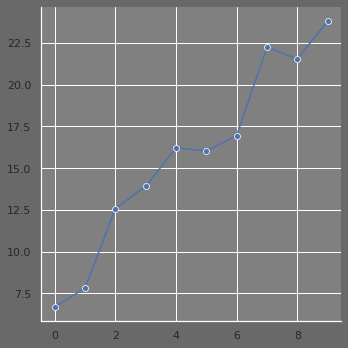

In [3]:
import seaborn as sns

sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'dimgray'})
# dark themes may be an addiction :)
sns.relplot(data=series, kind="line", marker="o")

Now to find the best fitting line for this graph we can use the minimize method, and since the data was originally based on $y=2x+5$ it makes sense to start it off at $m=2$ and $n=5$, the difference in those values will be caused by the error we have added on the data.

In [4]:
def sfunc(mn_coeffs, ys, xs):
    st = 0
    m, n = mn_coeffs
    
    for i in range(len(ys)):
        si = (ys[i] - (m*xs[i] + n))**2
        st += si
        
    return st


print(minimize(sfunc, [2, 5], args=(dataset1y, dataset1x)))

# let's also calculate the mean while we are at it:
ym = dataset1y.mean()
print(f"\nMean value of y = {ym}")

      fun: 14.564302772637767
 hess_inv: array([[ 0.02145317, -0.14068814],
       [-0.14068814,  0.9820752 ]])
      jac: array([ 7.15255737e-07, -8.34465027e-07])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 2
     njev: 5
   status: 0
  success: True
        x: array([1.86301461, 5.52724859])

Mean value of y = 15.77382899214074


Now let's put all our values into one dataframe and graph them to see how we did:

In [5]:
x_values = np.array(range(1,11))  # x values ranging from 1 to 10
linefity = x_values * 1.86301461 + 5.52724859  # the values we have obtained from minimize
# Note: We weren't able to directly call these values from the result, so we copy-pasted.
# we did set the random seed however, so it shouldn't cause problems when re-run.

linefit_series = pd.Series(linefity)
ym_series = pd.Series(np.ones(10) * ym)  # a series where all values are the mean of y

df = pd.concat([series, linefit_series, ym_series], axis=1)  # all together now!
df.rename(columns={0:"y values", 1:"line fit", 2:"mean"}, inplace=True)
df = df.set_index(x_values)
df

,y values,line fit,mean
1,6.680900,7.390263,15.773829
2,7.815022,9.253278,15.773829
3,12.578287,11.116292,15.773829
4,13.904311,12.979307,15.773829
5,16.206939,14.842322,15.773829
6,16.026006,16.705336,15.773829
7,16.943808,18.568351,15.773829
8,22.253406,20.431365,15.773829
9,21.524492,22.294380,15.773829
10,23.805119,24.157395,15.773829


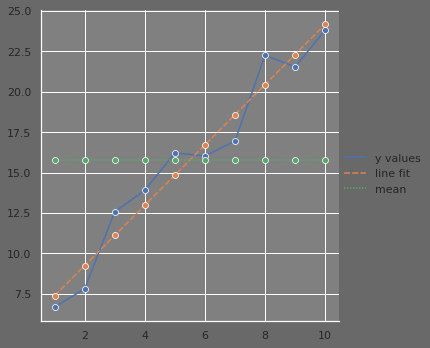

In [6]:
sns.relplot(data=df, kind="line", marker="o")

So we can see the mean is a rather pathetic fit overall, it only gets close to the values close to the middle, as we would expect. We can also get numerical data on how far off the mean is from each point on the dataset, and compare it to our line:

In [7]:
def error_func(y_org, y_fit):
    err = 0
    
    for i in range(len(y_org)):
        err += np.sqrt((y_org[i] - y_fit[i])**2)
    
    return err

mean_error = error_func(df["y values"].values, df["mean"].values)
line_fit_error = error_func(df["y values"].values, df["line fit"].values)

print(f"Total error for the mean: {mean_error}")
print(f"Total error for the minimize line fit: {line_fit_error}")

Total error for the mean: 44.23359055539191
Total error for the minimize line fit: 11.147312076405264


A significant difference, that would get more and more significant for higher slope values.

-----------------------------------

# Questions 2 & 3:

Defining the error values between our desired line and the values at hand as $s_i$:

$$
s_i = [y_i - (mx_i + n)]^2
$$

$$\\
s_i = y_i^2 - 2y_imx_i - 2yn + m^2\,x_i^2 + 2mx_i\,n +n^2 
$$

To minimize this error, we have to minimize the $s_i$ values for all points of $(x_i,y_i)$ for both m and n. To do this we can sum them all up and set their partial derivatives with respect to m and n equal to zero to find their respective stationary points. Since there are no limits to how far the line can get from any certain point $y_i$, the stationary points we find will be the minimum values we are looking for.



$$
\sum_{i=1}^N \,\frac{\partial s_i}{\partial m} = 0
$$

$$\\
\sum_{i=1}^N \,\frac{\partial s_i}{\partial n} =0
$$

$$\\
\left(\sum_{i=1}^N 2x_i^2 \right)\,m + \left(\sum_{i=1}^N 2x_i \right) n = \left(\sum_{i=1}^N 2x_i\,y_i \right)
$$

$$\\
\left(\sum_{i=1}^N 2x_i \right)\,m + \left(\sum_{i=1}^N 2 \right) n = \left(\sum_{i=1}^N 2y_i \right)
$$


Since the sums in the equations are finite and constant values, we can rewrite these as a set of two equations:

$$
A_{11}m+A_{12}n=B_{11}\\
A_{12}m+A_{22}n=B_{12}
$$
 

And from here all that is left to do is solve for m and n (or ask the linalg module to do it for us 8).

In [8]:
dataset2 = np.array([[1,2,3,4,5], [4.9142, 7.1201, 8.8456, 10.8113, 13.2231]])
x = dataset2[0]
y = dataset2[1]
A11 = A12 = A22 = B11 = B12 = 0
for i in range(0, dataset2.shape[1]):
    A11 += 2*x[i]**2
    A12 += 2*x[i]
    A22 += 2
    B11 += 2*x[i]*y[i]
    B12 += 2*y[i]
    
# defining our equation set in matrices:

coeff = np.array([[A11, A12],[A12, A22]])
res = np.array([B11, B12])
a0 = np.linalg.solve(coeff, res)[0]
a1 = np.linalg.solve(coeff, res)[1]

print(f"Value of a0, aka. m: {a0} \nValue of a1, aka. n: {a1}")

Value of a0, aka. m: 2.0308999999999986 
Value of a1, aka. n: 2.8901600000000043


In [9]:
from scipy.optimize import minimize

dataset2 = np.array([[1,2,3,4,5], [4.9142, 7.1201, 8.8456, 10.8113, 13.2231]])
x = dataset2[0]
y = dataset2[1]


def sfunc(mn_coeffs, ys, xs):
    st = 0
    m, n = mn_coeffs
    
    for i in range(len(y)):
        si = (ys[i] - (m*xs[i] + n))**2
        st += si
        
    return st


print(minimize(sfunc, [2, 2], args=(y, x)),'\n\n')
print("Using the minimize function:\n")
print(f"Value of a0, aka. m: {2.03089997}\nValue of a1, aka. n: {2.89016008}")

      fun: 0.11998931200000938
 hess_inv: array([[ 0.05, -0.15],
       [-0.15,  0.55]])
      jac: array([6.51925802e-09, 2.79396772e-09])
  message: 'Optimization terminated successfully.'
     nfev: 15
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([2.03089997, 2.89016008]) 


Using the minimize function:

Value of a0, aka. m: 2.03089997
Value of a1, aka. n: 2.89016008


We can see small differences of accuracy between the two different sets of values we have found, but for practical purposes they are the same for this dataset.

# Question 4:

For a linear dataset like we have used, there doesn't seem to be much of a difference. In fact we could argue that the least squares method is easier to use, and yields results with more precission without having to do extra computing, and all we really needed to do was add a bunch of known numbers in a loop and solve two equations for them. With the minimizer method more and more computation is required as higher precission is required. 

For different kinds of datasets it is a different story however. For example, for a second degree polinomial dataset the best fitting curve will have the form $Ax^2 + Bx + C$, using the minimizer method all we need to do is change our function from $mx+n$ to a such polinomial function and try optimizing that for all the data. With the least squares method however, we need to do more math, and we $\textit{definitely}$ don't want to do math in a numerical analysis course.

### Here's a polinomial fit:

Let's give it a try, with a function $y = 2x^2 + 3x +5 $

In [10]:
x_values = np.array(range(1,11))
poly_data = 3*(x_values**2) + 3 * x_values + 5
poly_data = np.array(poly_data, dtype=float)
np.random.seed(353)

for i in range(len(poly_data)):
    error = np.random.rand()*10 - 5  # let's go for a larger error, as the values are larger now
    poly_data[i] += error

poly_df1 = pd.DataFrame(poly_data).set_index(x_values)
poly_df1 = poly_df1.rename(columns={0:"y values"})

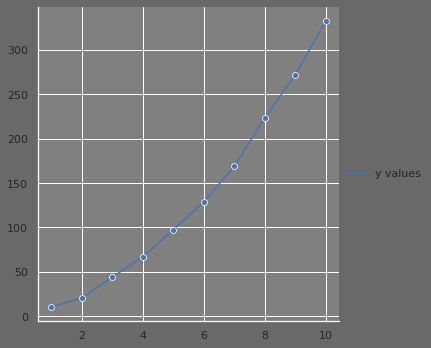

In [11]:
sns.relplot(data=poly_df1, kind="line", marker="o")

In [12]:
def poly_fit(coeffs, y, x):
    A, B, C = coeffs
    total_err = 0
    
    for i in range(len(y)):
        err_i = (y[i] - (A*x[i]**2 + B*x[i] + C))**2
        total_err += err_i
        
    return total_err

print(minimize(poly_fit, [3, 3, 5], args=(poly_df1["y values"].values, x_values)))
    

      fun: 51.69772371983757
 hess_inv: array([[ 0.00094697, -0.01041667,  0.02083334],
       [-0.01041667,  0.12064396, -0.26250005],
       [ 0.02083334, -0.26250005,  0.69166677]])
      jac: array([0.00000000e+00, 4.76837158e-07, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([2.88853997, 3.95208952, 3.60237687])


In [13]:
polyfit_data = 2.88853997*(x_values**2) + 3.95208952 * x_values + 3.60237687
polyfit_df = pd.DataFrame(polyfit_data).set_index(x_values)
poly_df = pd.concat([poly_df1, polyfit_df], axis=1)
poly_df.rename(columns={0:"curve fit"}, inplace=True)


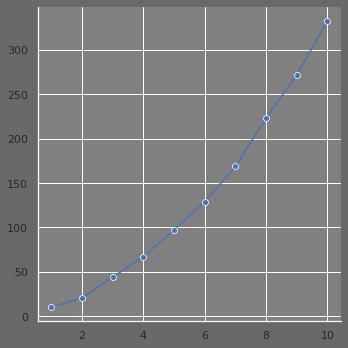

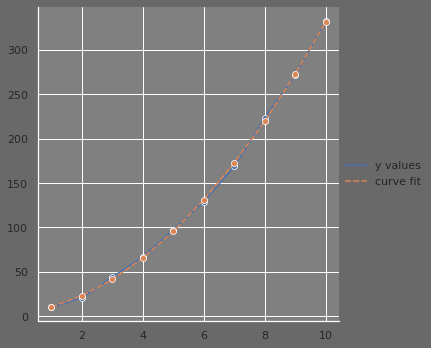

In [14]:
sns.relplot(data=poly_df["y values"], kind="line", marker="o")
sns.relplot(data=poly_df, kind="line", marker="o")

There we go, with little to no extra work, we were able to adapt the minimizer function to work perfectly with a polinomial. All we need to do to add another degree to the function is rewrite the equation in the error function and add another coefficient.

Let's compare the workload to the least squares method:

$$ S_i = \left[ y_i - \left( Ax_i^2 + Bx_i + C\right)\right]^2 $$
<br>
$$ S_i = y_i^2 -2y_i\left(Ax_i^2 + Bx_i + C\right) + \left( Ax_i^2 + Bx_i + C\right)^2$$

Aaand yada yada, by differentiating with respect to A, B and C and setting the derivatives to zero we are able to minimize them, and in return we get three distinc equations with three unknowns:

$$\left(\sum_i^n1\right)C + \left(\sum_i^n x_i\right)B + \left(\sum_i^n x_i^2\right)A = \left(\sum_i^n y_i\right)$$

$$\left(\sum_i^n x_i\right)C + \left(\sum_i^n x_i^2\right)B + \left(\sum_i^n x_i^3\right)A = \left(\sum_i^n x_iy_i\right)$$

$$\left(\sum_i^n x_i^2\right)C + \left(\sum_i^n x_i^3\right)B + \left(\sum_i^n x_i^4\right)A = \left(\sum_i^n x_i^2y_i\right)$$

$$ a_{11}C + a_{12}B + a_{13}A = b_{1} $$
$$ a_{21}C + a_{22}B + a_{23}A = b_2 $$
$$ a_{31}C + a_{32}B + a_{33}A = b_3 $$

In [15]:
a11 = a12 = a13 = b1 = a21 = a22 = a23 = b2 = a31 = a32= a33 = b3 = 0
ys = poly_df["y values"].values
xs = poly_df.index.values

for i in range(len(ys)):
    a11 += 1
    a12 += xs[i]
    a13 += xs[i]**2
    b1 += ys[i]
    a21 += xs[i]
    a22 += xs[i]**2
    a23 += xs[i]**3
    b2 += xs[i]*ys[i]
    a31 += xs[i]**2
    a32 += xs[i]**3
    a33 += xs[i]**4
    b3 += xs[i]**2 * ys[i]

# now for the matrices:

coeffs = np.array([[a11, a12, a13], [a21, a22, a23], [a31, a32, a33]])
results = np.array([b1, b2, b3])
coeffs
A = np.linalg.solve(coeffs, results)[2]
B = np.linalg.solve(coeffs, results)[1]
C = np.linalg.solve(coeffs, results)[0]

ls_values = A*xs**2 + B*xs + C
ls_poly_fit = pd.DataFrame(ls_values).set_index(xs)

print(f"Coefficients from least squares:\n\nA = {A},\nB = {B},\nC = {C}.")
print(f"\n\nCoefficients from minimizer:\n\nA = {2.88853997},\nB = {3.95208952},\nC = {3.60237687}.")

Coefficients from least squares:

A = 2.8885402694443623,
B = 3.9520862418645732,
C = 3.6023832804183376.


Coefficients from minimizer:

A = 2.88853997,
B = 3.95208952,
C = 3.60237687.


In [16]:
poly_df_new = pd.concat([poly_df, ls_poly_fit], axis=1)
poly_df_new.rename(columns={0:"least squares"}, inplace=True)
poly_df_new

,y values,curve fit,least squares
1,10.361800,10.443006,10.443010
2,20.630045,23.060716,23.060717
3,44.156575,41.455505,41.455504
4,66.808622,65.627374,65.627373
5,97.413877,95.576324,95.576321
6,129.052012,131.302353,131.302350
7,168.887615,172.805462,172.805460
8,223.506812,220.085651,220.085650
9,272.048985,273.142920,273.142921
10,332.610237,331.977269,331.977273


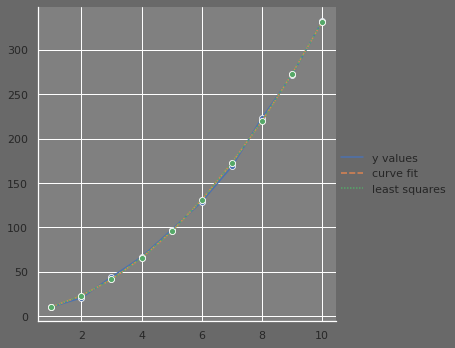

In [17]:
sns.relplot(data=poly_df_new, kind="line", marker="o")

We can hardly even tell them appart from the values and the graph, so looks like they still achieve the same results after all. However in the least squares method, for each degree of x added to the function, we get an extra equation to solve, and a bunch of binomial expansion/differentiation. <br> <br>(Not to mention, this may be the most code I've written to prove a point. :)
<br> <br>
Of course, we don't have to derive the formulae for the least squares method every time, there is a general equation for it, but we always have to write so much more code just to compute the sums required. The minimize method was significantly more manageable and took significantly less time to write out. <br> <br>So just for it's effects on our happiness and mental well-being, the minimize method seems to be the winner!

# References:


Chapra - Numerical Methods for Engineers - $7_{th}$ Edition:<br>
    Chapter 17.1 on Linear Regression<br>
    Chapter 17.2 on Polinomial Regression<br>
<br>
Some links:
<br>  
https://stackoverflow.com/questions/13670333/multiple-variables-in-scipys-optimize-minimize
<br>https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931
<br>https://towardsdatascience.com/linear-regression-using-least-squares-a4c3456e8570
